In [1]:
import pandas as pd 

B1 = pd.read_csv('../MNN2017/Simulations/B1_original.csv').to_numpy().T
B2i = pd.read_csv('../MNN2017/Simulations/B2i_original.csv').to_numpy().T
B2ii = pd.read_csv('../MNN2017/Simulations/B2ii_original.csv').to_numpy().T
clust2i = pd.read_csv('../MNN2017/Simulations/clust2i.csv').to_numpy().reshape(1000,)
clust2ii = pd.read_csv('../MNN2017/Simulations/clust2ii.csv').to_numpy().reshape(1000,)

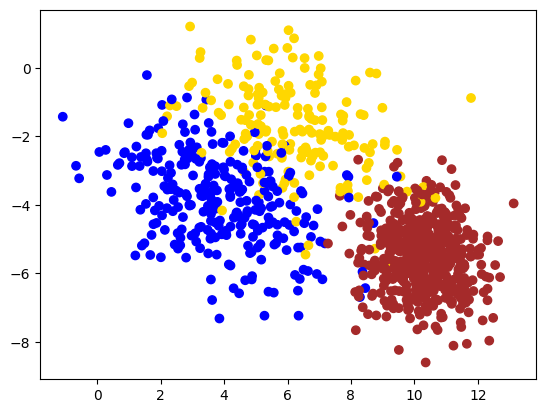

In [3]:

import matplotlib.pyplot as plt
plt.scatter(B1[:, 0], B1[:, 1], c=clust2ii)

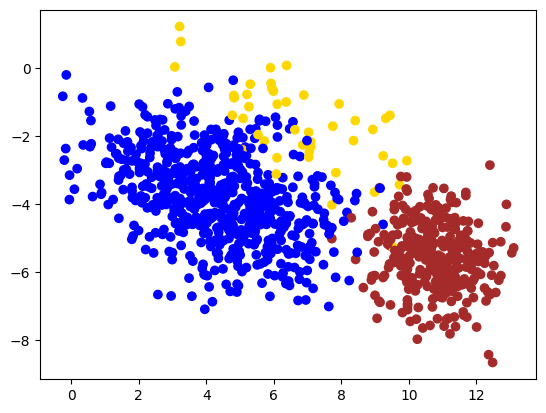

In [5]:
plt.scatter(B2i[:, 0], B2i[:, 1], c=clust2i)

In [8]:
import numpy as np
np.unique(clust2i, return_counts=True)

(array(['blue', 'brown', 'gold'], dtype=object), array([636, 317,  47]))

In [9]:
np.unique(clust2ii, return_counts=True)

(array(['blue', 'brown', 'gold'], dtype=object), array([282, 540, 178]))

### MNN

In [10]:
import numpy as np 
def l2_norm(in_matrix):
    return np.linalg.norm(x=in_matrix, axis=0)


def scale_columns(in_matrix, scale_vector):
    return np.divide(in_matrix, scale_vector)


In [12]:
ref_batch_in = scale_columns(B1, l2_norm(B1))
new_batch_in = scale_columns(B2i, l2_norm(B2i))

In [13]:
from scipy.spatial import cKDTree

def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    k_index_1 = cKDTree(data1).query(x=data2, k=k1, workers=n_jobs)[1]
    k_index_2 = cKDTree(data2).query(x=data1, k=k2, workers=n_jobs)[1]
    mutual_1 = []
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
        for index_1 in k_index_1[index_2]:
            if index_2 in k_index_2[index_1]:
                mutual_1.append(index_1)
                mutual_2.append(index_2)
    return mutual_1, mutual_2

k = 10
n_jobs = 5
mnn_ref, mnn_new = find_mutual_nn(data1=ref_batch_in,
                                  data2=new_batch_in, k1=k, k2=k,  n_jobs=n_jobs)

In [14]:
import numpy as np

def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    #w
    B = data1[mnn1] - data2[mnn2]
    mnn_index, mnn_count = np.unique(mnn2, return_counts=True)
    vect_reduced = np.zeros((data2.shape[0], B.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, B):
        vect_reduced[index] += ve
    vect_avg = np.divide(vect_reduced[mnn_index], mnn_count.astype(np.float32)[:, None])
    #D_c_i
    exp_distance = np.exp(-kdist(data2_or_raw2, data2_or_raw2[mnn_index]) / sigma)
    density = np.sum(exp_distance[mnn_index], axis=0)
    mult = np.divide(exp_distance, density)
    total_prob = np.sum(mult, axis=1, keepdims=True)
    output = np.dot(mult, vect_avg)

    return np.divide(output, total_prob)

In [15]:
def kdist(m, n):
    dist = np.zeros((m.shape[0], n.shape[0]), dtype=np.float32)
    for i in range(m.shape[0]):
        for j in range(n.shape[0]):
            dist[i, j] = np.dot(m[i], n[j])
    return dist

In [16]:
sigma = 1
correction_in = compute_correction(ref_batch_in, new_batch_in, mnn_ref, mnn_new,
                                           new_batch_in, sigma)

In [17]:
conc = np.concatenate((ref_batch_in, new_batch_in + correction_in), axis=0)
from sklearn.manifold import TSNE

embedding1 = TSNE(n_components=2, learning_rate='auto',
         init='random', perplexity=50).fit_transform(conc)


# Clusters

In [22]:
clus = np.concatenate((clust2ii, clust2i))

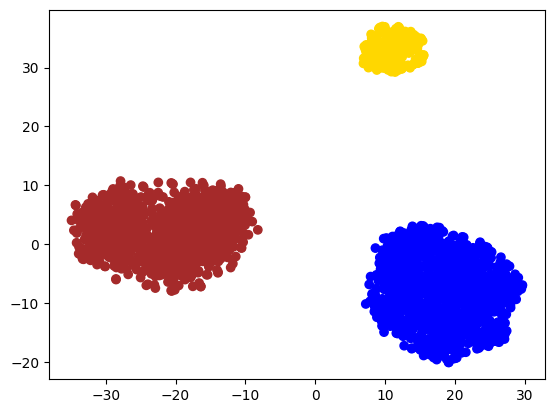

In [23]:
import matplotlib.pyplot as plt

plt.scatter(embedding1[:, 0], embedding1[:, 1], c=clus)

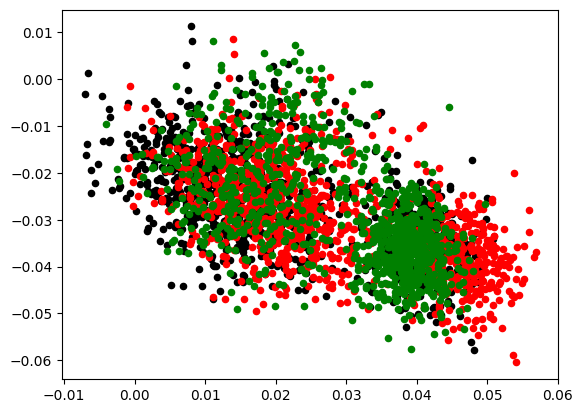

In [24]:
plt.scatter((new_batch_in + correction_in)[:, 0], (new_batch_in + correction_in)[:, 1], marker='o', s=20, c='black')
plt.scatter((new_batch_in)[:, 0], (new_batch_in)[:, 1], marker='o', s=20, c='red')
plt.scatter((ref_batch_in)[:, 0], (ref_batch_in)[:, 1], marker='o', s=20, c='green')

In [25]:
conc = np.concatenate((ref_batch_in, new_batch_in), axis=0)

In [26]:
from sklearn.manifold import TSNE

embedding1 = TSNE(n_components=2, learning_rate='auto',
         init='random', perplexity=50).fit_transform(conc)


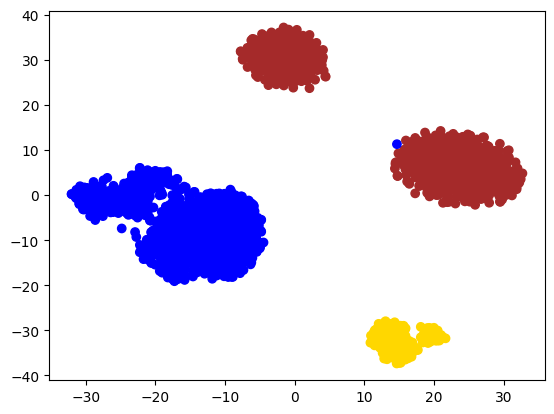

In [27]:
import matplotlib.pyplot as plt

plt.scatter(embedding1[:, 0], embedding1[:, 1], c=clus)

In [31]:
conc = np.concatenate((B1, B2i), axis=0)

In [32]:
from sklearn.manifold import TSNE

embedding1 = TSNE(n_components=2, learning_rate='auto',
         init='random', perplexity=100).fit_transform(conc)


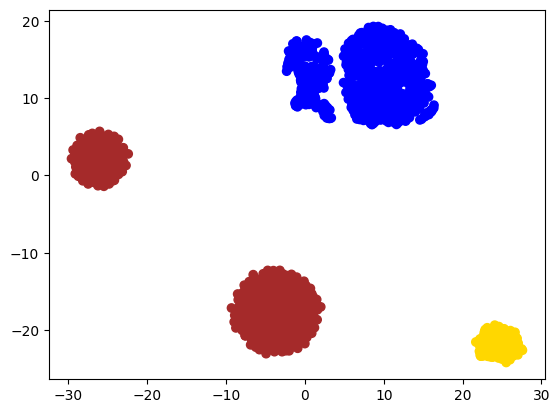

In [33]:
plt.scatter(embedding1[:, 0], embedding1[:, 1], c=clus  )